<a href="https://colab.research.google.com/github/restrepo/COVID-19/blob/master/covid_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 data

Use of [public Covid-19 in GitHub](https://github.com/CSSEGISandData/COVID-19) data from: 
[Center for Systems Science and Engineering (CSSE)](https://systems.jhu.edu/):

* Hongru Du, Lauren Gardner, and Ensheng Dong, An interactive web-based dashboard to track COVID-19 in real time, http://www.thelancet.com/infection Published:February 19, 2020, DOI:https://doi.org/10.1016/S1473-3099(20)30120-1

As an example of use of the data, we want to reproduce the results of:
* [Así evoluciona la curva del Coronavirus en España y en cada CCAA](https://elpais.com/sociedad/2020/03/13/actualidad/1584091954_865510.html)

<img src='https://github.com/restrepo/Covid-19/blob/master/img/elpais.png?raw=1' height="80" >

and to make similar plots for other countries


In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
import pandas as pd
import re
#See https://strftime.org/
import datetime
import time
import numpy as np
from scipy import optimize as opt
import warnings
warnings.filterwarnings("ignore")

In [29]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def date_range(date_start='2/23/20',date_end='3/03/20',date_step=1,
               strptime_format="%m/%d/%y",
               strftime_format="%-m/%-d/%y"):
    dr=[]
    start = datetime.datetime.strptime(date_start,strptime_format )
    end = datetime.datetime.strptime(date_end,strptime_format)
    step = datetime.timedelta(days=date_step)
    while start <= end:
        #avoid leading zeroes: https://stackoverflow.com/a/2073189/2268280
        dr.append(start.strftime(strftime_format))
        start += step
    return dr    
    
def index_field(df,column,filter=None):
    '''
    WARNING: Nonumerical columns are dropped
    
    Parameters:
    ----------
    filter: list, default None
        Select only the columns in this list
    '''
    dff=df.copy()
    if filter:
        dff=df[[column]+list(filter)]
    return dff.groupby(column).sum()

## Load data

In [30]:
ALL_DATA=True
cvd=None
cvr=None
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataDir='master/csse_covid_19_data/csse_covid_19_time_series/'
DataFile='time_series_covid19_confirmed_global.csv'
cva=pd.read_csv('{}{}{}'.format(DataSource,DataDir,DataFile))
cva=cva.reset_index(drop=True)
if ALL_DATA:
    DataDeaths='time_series_covid19_deaths_global.csv'
    time.sleep(1)
    cvd=pd.read_csv('{}{}{}'.format(DataSource,DataDir,DataDeaths))
    cvd=cvd.reset_index(drop=True)
    #DEPRECATED
    #time.sleep(1)
    #DataRecovered='time_series_19-covid-Recovered.csv'
    #cvr=pd.read_csv('{}{}{}'.format(DataSource,DataDir,DataRecovered))
    #cvr=cvr.reset_index(drop=True)

#Special cases
c='Hong Kong'
try:
    cva.loc[cva[cva['Province/State']==c].index[0],'Country/Region']=c
    cvd.loc[cvd[cvd['Province/State']==c].index[0],'Country/Region']=c
except IndexError:
    pass    

In [31]:
dc=[ c for c in cva.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]
if cvd is not None:
    dd=[ c for c in cvd.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]

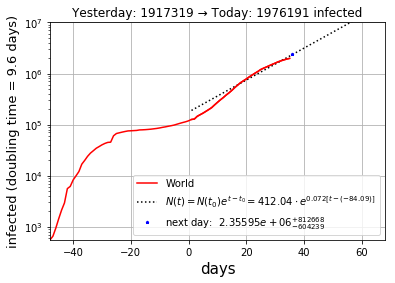

In [32]:
extra_days=-15
max_forecast=10000000
tunep0_3=20
exp_start=49
date_start=dc[exp_start]#dc[0]
date_end=dc[-1]
ylinlog='log'
y=index_field(cva,"Country/Region",filter=
              date_range(date_start=date_start,date_end=date_end)
              ).sum()
x=list( range(1,len(y)+1) )
Y=index_field(cva,"Country/Region",filter=
              date_range(date_start=dc[0],date_end=dc[-1])
              ).sum()
X=list( range(1,len(Y)+1) )
#y=Y
#x=X

xx=list( range(X[0],X[-1]+extra_days) )
exp_fit = opt.curve_fit(exponential_model,x,y,p0=[1,0.4,tunep0_3])
try:
    Δb=np.sqrt(exp_fit[1][1,1])
except:
    Δb=0
if min(Y)>0:
    ymin=min(Y)
else:
    ymin=1

#Doubling time
N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
if exponential_model(t0,N0,g,t0)==N0:
    Td=np.log(2)/g
else:
    Td=None
if Td:
    dt=re.sub('\.0\s',' ', '(doubling time = {} days)'.format(Td.round(1)
        ))
    texmodel='N(t)=N(t_0)e^{t-t_0}='
else:
    texmodel=''
    dt=''

#Prediction next day
exp_fit_world=exp_fit[0].copy()
exponential_model_world=lambda x: exponential_model(x, exp_fit_world[0],exp_fit_world[1],exp_fit_world[2]  )
infc=exponential_model_world(x[-1]+1  )
pinfc=exponential_model(x[-1]+1, exp_fit_world[0],exp_fit_world[1]+Δb,exp_fit_world[2]  )-infc
minfc=infc-exponential_model(x[-1]+1, exp_fit_world[0],exp_fit_world[1]-Δb,exp_fit_world[2]  )
next_day=r'next day:  $%g^{+%g}_{-%g}$' %(
                        int( infc ),int( pinfc ),int( minfc )  )


plt.plot(x,y,'r-',label='World')
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%s%g\cdot e^{%g[t-(%g)]}$' %(texmodel,
                                             exp_fit[0][0].round(2),
                                             exp_fit[0][1].round(3),
                                             exp_fit[0][2].round(2)) )
plt.plot(x[-1]+1,infc,'b*',markersize=3,
         label=next_day
         )
plt.plot(np.array(X)-exp_start,Y,'r-')
plt.legend()
plt.xscale('linear')
plt.yscale(ylinlog)
plt.xlabel('days',size=15)
plt.ylabel('infected '+dt,size=13 )
plt.title('Yesterday: {} → Today: {} infected'.format(y[-2],y[-1]))
if ylinlog=='linear':
    xmax=x[-1]+2
    ymax=y[-1]+infc+Δb
else:
    xmax=xx[-1]
    ymax=max_forecast+30000
plt.xlim(xx[0]-exp_start,xmax)
plt.ylim(ymin,ymax)
plt.grid()
plt.savefig('world.png')

## Reproduce "El País" plot
Set of minimal number of infections to catch up the exponential growth: `mininf=50`

In [33]:
cv=index_field(cva,"Country/Region",filter=dc)

Text(0, 0.5, 'infected')

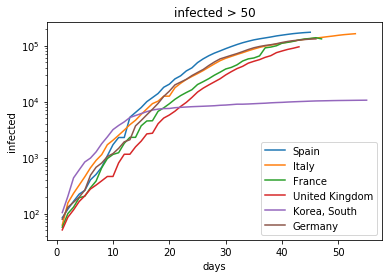

In [34]:
cntr=['Spain','Italy','France','United Kingdom','Korea, South','Germany']

mininf=50
for c in cntr:
    y=[l for l in cv.loc[c].tolist() if l>mininf]
    ylen=len(y)
    x=list( range( 1,ylen+1 ) )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))
    
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infected > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infected')
#plt.xlim(1,10)
#plt.ylim(1,200)
#plt.savefig('elpais_recover_2020_03_16.png')

### From [Donde estará el pico...](https://sistemaencrisis.es/2020/03/20/covid-19-donde-estara-el-pico-de-decesos-estableciendo-una-cota-inferior-en-base-a-la-curva-china/)

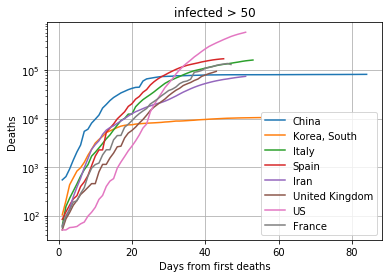

In [35]:
cntr=['China','Korea, South','Italy','Spain','Iran','United Kingdom','US','France']

deaths=50
for c in cntr:
    y=[l for l in cv.loc[c].tolist() if l>mininf]    
    ylen=len(y)
    x=list( range( 1,ylen+1 ) )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))
    
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.title('infected > {}'.format(mininf))
plt.xlabel('Days from first deaths')
plt.ylabel('Deaths')
plt.grid()
#plt.xlim(1,10)
#plt.ylim(1,200)
#plt.savefig('elpais_recover_2020_03_16.png')

## Make similar plots for all the countries

Country Lat
--------------------
Albania 41.1533
Bahrain 26.0275
Belarus 53.7098
Bolivia -16.2902
Brunei 4.5353
Cambodia 11.55
Congo (Kinshasa) -4.0383
Georgia 42.3154
Ghana 7.9465
Hong Kong 22.3
Iraq 33.0
Japan 36.0
Jordan 31.24
Kenya -0.0236
Kosovo 42.602636
Kuwait 29.5
Kyrgyzstan 41.2044
Liechtenstein 47.14
Madagascar -18.7669
Malta 35.9375
Mauritius -20.2
Monaco 43.7333
Montenegro 42.5
Nigeria 9.082
Oman 21.0
Paraguay -23.4425
Rwanda -1.9403
San Marino 43.9424
Senegal 14.4974
Singapore 1.2833
Slovakia 48.669
Sri Lanka 7.0
Taiwan* 23.7
Trinidad and Tobago 10.6918
United Arab Emirates 24.0
Venezuela 6.4238
Vietnam 16.0
West Bank and Gaza 31.9522
--------------------


(40, 300000)

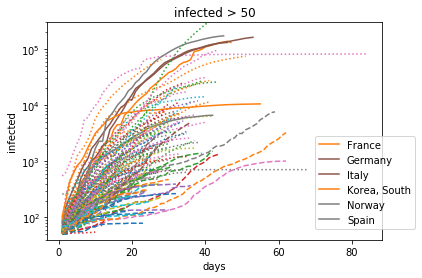

In [36]:
print('Country','Lat')
print('-'*20)
cntr=cv.index
low_countries=[]
mininf=50
days_after=13
maxinf=300
for c in cntr:
    y=[l for l in cv.loc[c].tolist() if l>mininf]    
    ylen=len(y)
    x=list( range( 1,ylen+1 ) )
    if len(x)>days_after and y[days_after]<maxinf:
        low_countries.append(c)
        print(c,cva[cva['Country/Region']==c]['Lat'].tolist()[0])
    if c in ['Spain','Italy','France','Norway','Korea, South','Germany']:
        plt.plot(x,y,label='{}'.format(c))
    elif c in low_countries:
        plt.plot(x,y,'--')#,label='{}'.format(c))
    else:
        plt.plot(x,y,':')

print('-'*20)
plt.legend(loc=(0.8,0.05))
plt.xscale('linear')
plt.yscale('log')
plt.title('infected > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infected')
#plt.xlim(10,20)
plt.ylim(mininf-10,300000)

## Slow-exponential-growth countries

Country Lat
--------------------
Australia -35.4735
Georgia 42.3154
Hong Kong 22.3
Japan 36.0
Kuwait 29.5
Malaysia 2.5
Oman 21.0
San Marino 43.9424
Singapore 1.2833
Taiwan* 23.7
Thailand 15.0
Vietnam 16.0
West Bank and Gaza 31.9522
--------------------


(6.372046400234566, 10000)

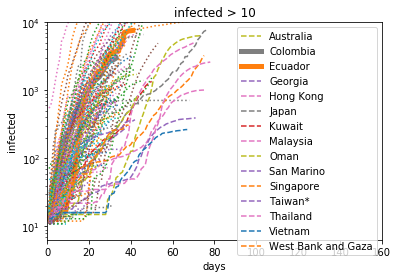

In [37]:
print('Country','Lat')
print('-'*20)
cntr=cv.index
low_countries=[]
mininf=10
days_after=35
maxinf=400
for c in cntr:
    y=[l for l in cv.loc[c].tolist() if l>mininf] 
    ylen=len(y)
    x=list( range( 1,ylen+1 ) )
    if len(x)>days_after and y[days_after]<maxinf:
        low_countries.append(c)
        print(c,cva[cva['Country/Region']==c]['Lat'].tolist()[0])
    if c in ['Ecuador','Colombia']:
        plt.plot(x,y,label='{}'.format(c),lw=5)
    elif c in low_countries:
        plt.plot(x,y,'--',label='{}'.format(c))
    else:
        plt.plot(x,y,':')

print('-'*20)
plt.legend(loc='upper right')
plt.xscale('linear')
plt.yscale('log')
plt.title('infected > {}'.format(mininf))
plt.xlabel('days')
plt.ylabel('infected')
plt.xlim(0,160)
plt.ylim(mininf-10,10000)

To check the reason why some contries may no exhibit an strong exponential growth, see [References](./covid.ipynb#References) at the end


## Latin America

In [38]:
def growth_rate(Td):
    return np.log(2)/Td
#growth_rate(2.6)

In [39]:
mininf=50
maxdays=len([i for i in cv.loc['Spain'].tolist() if i > mininf ])

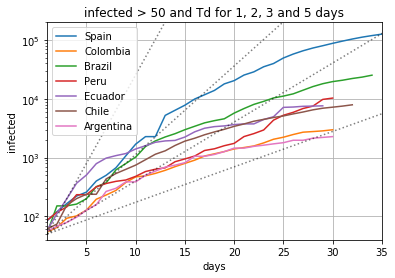

In [40]:
cntr=['Spain','Colombia','Brazil','Peru','Ecuador', 'Chile','Argentina']
xx=np.linspace(1,maxdays)
for c in cntr:
    y=[l for l in cv.loc[c].tolist() if l>mininf] 
    ylen=len(y)
    x=list( range( 1,ylen+1 ) )
    #plt.semilogy(x,y,label='{}'.format(c))
    plt.plot(x,y,label='{}'.format(c))

line1,=plt.plot(xx,exponential_model(xx,mininf,growth_rate(1),1),'k:',alpha=0.5)#,label='Double every 1 day')    
plt.plot(xx,exponential_model(xx,mininf,growth_rate(3),1),'k:',alpha=0.5)    
plt.plot(xx,exponential_model(xx,mininf,growth_rate(2),1),'k:',alpha=0.5)
plt.plot(xx,exponential_model(xx,mininf,growth_rate(5),1),'k:',alpha=0.5)


# Create a legend for the first line.
#first_legend = plt.legend(handles=[line1], loc='upper right')

# Add the legend manually to the current Axes.
#ax = plt.gca().add_artist(first_legend)

general_legend=plt.legend(loc='best')


plt.xscale('linear')
plt.yscale('log')
plt.title('infected > {} and Td for 1, 2, 3 and 5 days'.format(mininf))
plt.xlabel('days')
plt.ylabel('infected')
plt.xlim(1,35)
plt.ylim(40,200000)
plt.grid()
#plt.savefig('elpais_recover_2020_03_16.png')

## Fit to exponential model
See: Jupyter Notebook `covid19_analysis.ipynb`: [[local](./covid19.ipynb)] [[GitHub](https://github.com/restrepo/Covid-19/blob/master/covid.ipynb)] [[Colab](https://colab.research.google.com/github/restrepo/Covid-19/blob/master/covid.ipynb)] 

## Other models
* Fractal kinetics of COVID-19 pandemic, Anna L. Ziff, Robert M. Ziff
medRxiv 2020.02.16.20023820; doi: https://doi.org/10.1101/2020.02.16.20023820
    * (https://www.zdnet.com/article/graph-theory-suggests-covid-19-might-be-a-small-world-after-all/)
> Rather, the authors observed a period of initial exponential growth, followed by what's called a "power law," which is not the same thing.
* A mathematical model for the novel coronavirus epidemic in Wuhan, Chayu Yang, Jin Wang, Mathematical Biosciences and Engineering, 2020, 17(3): 2708-2724. doi: [10.3934/mbe.2020148](http://dx.doi.org/10.3934/mbe.2020148).
    * [SIR Model](https://es.wikipedia.org/wiki/Modelo_SIR)

* [Data minning](https://sistemaencrisis.es/2020/03/20/covid-19-donde-estara-el-pico-de-decesos-estableciendo-una-cota-inferior-en-base-a-la-curva-china/)

## References
About meteorological conditions for Covid-19

* Sajadi, Mohammad M. and Habibzadeh, Parham and Vintzileos, Augustin and Shokouhi, Shervin and Miralles-Wilhelm, Fernando and Amoroso, Anthony, Temperature and Latitude Analysis to Predict Potential Spread and Seasonality for COVID-19 (March 5, 2020). Available at SSRN: https://ssrn.com/abstract=3550308 or http://dx.doi.org/10.2139/ssrn.3550308
    * [El coronavirus en tierra caliente: ¿igual, peor o menos grave?](https://www.elespectador.com/coronavirus/el-coronavirus-en-tierra-caliente-igual-peor-o-menos-grave-articulo-909335)

* Wang, Jingyuan and Tang, Ke and Feng, Kai and Lv, Weifeng, High Temperature and High Humidity Reduce the Transmission of COVID-19 (March 9, 2020). Available at SSRN: https://ssrn.com/abstract=3551767 or http://dx.doi.org/10.2139/ssrn.3551767 
> $R = 3.968 - 0.0383\cdot \text{Temperature} - 0.0224\cdot \text{Relative Humidity}$
    * [Twitter thread](https://twitter.com/zuluagajorge/status/1239925580038049793)
* [Singapore contained Coronavirus. Could other countries learn from its approach?](https://www.weforum.org/agenda/2020/03/singapore-response-contained-coronavirus-covid19-outbreak/)
* [Will spring slow spread of coronavirus in northern hemisphere?](https://www.theguardian.com/world/2020/mar/11/will-spring-slow-spread-of-coronavirus-in-northern-hemisphere)
* [Coronavirus: Why You Must Act Now](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca)
* [Es muy probable que el SARS-COV-2 se atenúe y vuelva cada invierno, como la gripe](https://www.elespectador.com/coronavirus/es-muy-probable-que-el-sars-cov-2-se-atenue-y-vuelva-cada-invierno-como-la-gripe-articulo-909696)
> Las altas temperaturas son excelentes porque los coronavirus son muy sensibles al calor: cada día que pasan a 37 grados, pierden 10 veces su infectividad. Por tanto, en tres días calentitos se bajaría mil veces su capacidad de infección.
* Jin Bu, Dong-Dong Peng, Hui Xiao, Qian Yue, Yan Han, Yu Lin, Gang Hu, Jing Chen, Analysis of meteorological conditions and prediction of epidemic trend of 2019-nCoV infection in 2020, medRxiv 2020.02.13.20022715; doi: https://doi.org/10.1101/2020.02.13.20022715
> From a global perspective, cities with a mean temperature below 24 degree Celsius are all high-risk cities for 2019-nCoV transmission before June.

## Appendix

In [41]:
R=lambda T,H: 3.968 - 0.0383*T - 0.022*H

Global results in Fig. 4 (a) March (b) July in http://dx.doi.org/10.2139/ssrn.3551767

In [42]:
# Japan - July from paper
R(28,85)

1.0256

In [43]:
# Medellín - March from https://en.wikipedia.org/wiki/Medell%C3%ADn#Climate
R(23,65)

1.6571

In [44]:
# Bogotá - March from https://en.wikipedia.org/wiki/Bogot%C3%A1#Climate
R(15,75)

1.7435

## Model
See
https://www.youtube.com/watch?v=Kas0tIxDvrg&feature=youtu.be&t=249

$$N_d=(1+E p)^d N_0$$
where $d$ is the number of days, and $N_0$ is the intial number of infected

In [45]:
Ep=0.5
xlen=6
xx=list( list(range(1,xlen)) )
yy=[y[4]]+[int((1+Ep)**d*y[4]) for d in xx[:-1]]

In [46]:
xx

[1, 2, 3, 4, 5]

In [47]:
xini=xx[0]

In [48]:
y[xini:xini+xlen]

[68, 79, 97, 128, 158, 266]

In [49]:
cv.loc['Colombia'][-1]

2979

In [50]:
import IPython

In [ ]:
%%javascript
IPython.notebook.save_notebook()    

In [ ]:
import os
if os.getcwd()!='/content':    
    !git commit -am 'automatic update' 2>/dev/null > /dev/null
    !git push origin master 2>/dev/null > /dev/null